# **COCA Coronary Calcium and Chest CT - 3D Dataset**

## Sources:

Data - https://stanfordaimi.azurewebsites.net/datasets/e8ca74dc-8dd4-4340-815a-60b41f6cb2aa

# Import Dependencies

In [2]:
# File Support
try: 
    import pydicom as dcm
except:
    # Use try except for Google Colab
    !pip install pydicom
from pydicom.data import get_testdata_files
import xml
import xml.etree.ElementTree as ET 

# Base
import numpy as np
import pandas as pd
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from PIL import Image

# SK-learn
import sklearn

# Files
import os
from os.path import join, split
from glob import glob
import pickle

# Torch
import torch
from torch import nn
from torch.nn import Conv3d
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

# Config

In [3]:
class CFG:
    random_seed = 42
    gated = True
    path = "Coronary CT Data\Gated_release_final" if gated else "Coronary CT Data/deidentified_nongated"

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Reproducibility

In [5]:
def set_seed(seed=CFG.random_seed):
    print(f"Seed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed()

Seed: 42


# Helper Functions

In [6]:
def read_dicom(path):
    arr = dcm.dcmread(path).pixel_array
    arr = (arr-arr.min())/(arr.max()-arr.min())
    return arr

In [7]:
def parseXML(xmlfile): 
    # create element tree object 
    tree = ET.parse(xmlfile) 

    all_images = []

    images = tree.find("dict").find("array")
    images = images.findall("dict")

    # Images
    for image in images:
        image_data = {}
        arr = [i.text for i in image if i.tag not in ["array", "dict"]]
        
        for i in range(len(arr)//2):
            image_data[arr[2*i]] = arr[2*i+1]

        image_data['ROIs'] = []

        # ROI
        all_roi = image.find("array").findall('dict')
        for roi in all_roi:
            roi_data = {}
            arr = [i.text for i in roi if i.tag not in ["array", "dict"]]
        
            for i in range(len(arr)//2):
                roi_data[arr[2*i]] = arr[2*i+1]

            all_points = roi.findall('array')
            roi_data['point_mm'] = [i.text for i in all_points[0].findall("string")]
            roi_data['point_px'] = [i.text for i in all_points[1].findall("string")]
            
            image_data['ROIs'].append(roi_data)
        all_images.append(image_data)

    return all_images

In [8]:
class ChestCT:
    def __init__(self, xmlData : dict): # xmlData is 
        self.image_idx = xmlData['ImageIndex']
        path = join(CFG.path,f"patient\\{self.image_idx}")
        
        self.all_paths = glob(f"{path}/**/**.dcm") # Returns all dicom file paths for a specific patient
        
            
    def __len__(self):
        return len(self.all_paths)
    
    def display(self):
        pass

In [9]:
def create_segments(image_array, points):
    polygon = Polygon(points, closed=True, edgecolor='r', facecolor='r')
    polygon_indices = np.array(points)
    polygon_indices[:, 0] = np.clip(polygon_indices[:, 0], 0, 511)
    polygon_indices[:, 1] = np.clip(polygon_indices[:, 1], 0, 511)
    image_array[polygon_indices[:, 1], polygon_indices[:, 0]] = 1
    polygon_path = Path(polygon_indices)
    x, y = np.meshgrid(np.arange(512), np.arange(512))
    points = np.column_stack((x.flatten(), y.flatten()))
    mask = polygon_path.contains_points(points).reshape(512, 512)
    image_array[mask] = 1

    return image_array

In [10]:
def plot_image(img_path):
    img  = dcm.dcmread(img_path).pixel_array
    img_idx = str(int(split(img_path)[-1][8:-4]))
    
    patient_id = img_path.split("\\")[-3]
    label_path = join(CFG.path, f'calcium_xml\{patient_id}.xml')

    num_images = len(os.listdir(split(img_path)[0]))
    label_path = join(CFG.path, f'calcium_xml\{patient_id}.xml')

    print(f"Patient ID: {patient_id}")
    print(f"Image ID: {num_images-int(img_idx)}")

    try:
        labels = parseXML(label_path)
        indexes = [str(num_images-int(i['ImageIndex'])) for i in labels]
    except:
        indexes = []

    img_label = np.zeros((512,512))
    if img_idx in indexes:
        ROIs = labels[indexes.index(img_idx)]['ROIs']
        for roi in ROIs:
            points = (roi['point_px'])
            points = [(int(round(float(eval(point)[0]), 0)), int(round(float(eval(point)[1]), 0))) for point in points]
            if points:
                img_label = create_segments(img_label, points)
    
    
    norm = Normalize(vmin=0, vmax=255)
    overlay = np.stack((img*0.05,)*3, axis=2)
    overlay = norm(overlay)
    overlay[:,:,0] = overlay[:,:,0] + img_label

    fig, ax = plt.subplots(1,3, figsize=(10,10))
    for i in range(3):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].get_xaxis().set_ticks([])
        ax[i].get_yaxis().set_ticks([])

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("Image", fontsize=10)
    ax[1].imshow(img_label, cmap="inferno")
    ax[1].set_title("Label", fontsize=10)
    ax[2].imshow(overlay)
    ax[2].set_title("Overlay", fontsize=10)
    plt.show()
    
    

# Preview Data

In [11]:
image_paths = glob(f"{CFG.path}\\**\\**\\**\\*.dcm")
label_paths = glob(f"{CFG.path}\\patient\\**")
print(f"{len(image_paths)} images")
print(f"{len(label_paths)} patients")

40113 images
787 patients


## Plot Images

In [12]:
image_paths[0]

'Coronary CT Data\\Gated_release_final\\patient\\0\\Pro_Gated_CS_3.0_I30f_3_70%\\IM-6130-0001.dcm'

Patient ID: 226
Image ID: 22


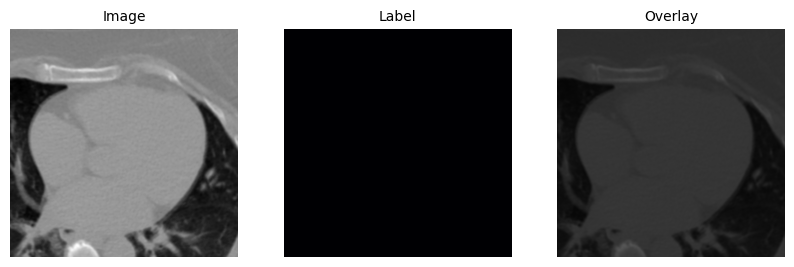

Patient ID: 127
Image ID: 17


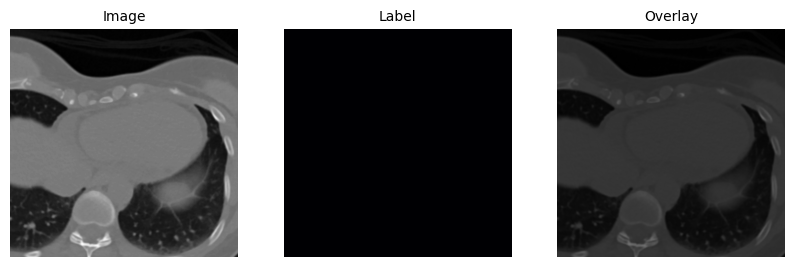

Patient ID: 417
Image ID: 77


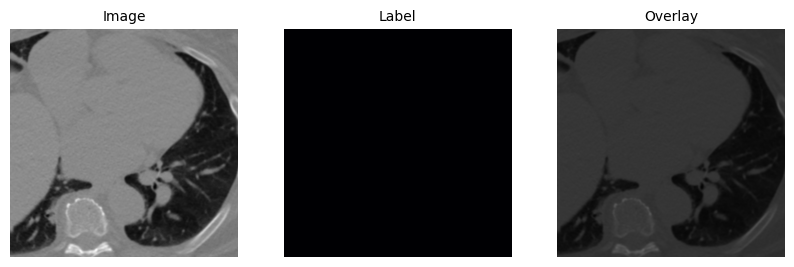

In [13]:
nSamples = 3
for i in range(nSamples):
    idx = random.randint(0,len(image_paths))
    plot_image(image_paths[idx])

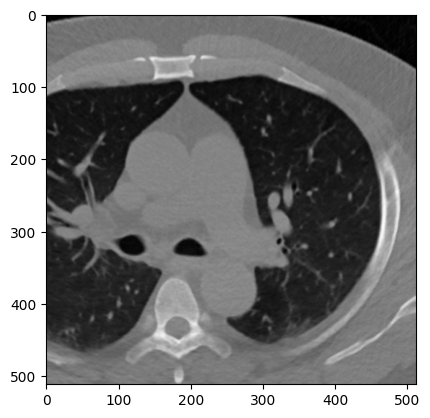

In [14]:
arr = read_dicom(image_paths[0])
plt.imshow(arr, cmap='gray')

## Check Uniformity

In [15]:
# orientations = set({})
# all_labels = glob(f"{CFG.path}/**/**.xml")
# for xml_file in all_labels:
#     labels = parseXML(xml_file)
#     for label in labels:
#         paths = ChestCT(label).all_paths
#         for i in paths:
#             scan = dcm.dcmread(i)
#             orientation = [str(int(i)) for i in scan["ImageOrientationPatient"].value]
#             orientations.add("".join(orientation))

# f"{len(orientations)} unique orientation(s)"

**All Images Have Same Orientation - No Transformation Needed**

# Create Dataset

In [16]:
class CTScanDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.patients_list = glob(f"{data_dir}\patient\*")
        self.all_images = glob(f"{data_dir}\patient\*\*")
        self.all_dir_lens = [len(os.listdir(split(i)[0])) for i in self.all_images]        


    def __len__(self):
        return len(self.patients_list)
    
    def __getitem__(self, idx): # Return tuple (x, y)
        patients_path = self.patients_list[idx] # Get Patients Path
        patient_id = patients_path.split("\\")[-1]
        image_path = self.all_images[idx] 
        
        all_images = glob(image_path + "/*.dcm") # Folder of all images for patient
        numImages = len(all_images)

        # Images
        images = []
        for path in all_images:
            img  = dcm.dcmread(path).pixel_array
            img = np.divide((img - np.min(img)),np.max(img)) # Normalize
            img = img.reshape(1, img.shape[0], img.shape[1]) 
            img = img.astype(np.float32)
            images.append(img)
        
        img_stack = np.stack(images)

        # Labels
        labels = []
        patient_labels = parseXML(patients_path)
        indexes = [str(numImages-int(i['ImageIndex'])) for i in labels]
        for i in range(numImages):
            if i in indexes:
                ROIs = labels[indexes.index(i)]['ROIs']
                for roi in ROIs:
                    points = (roi['point_px'])
                    points = [(int(round(float(eval(point)[0]), 0)), int(round(float(eval(point)[1]), 0))) for point in points]
                    if points:
                        img_label = create_segments(img_label, points)

                        img = img.astype(np.float32)

                        labels.append(img.astype(np.float32), img_label.astype(np.float32))
                    else:
                        labels.append(np.zeros(512,512))
            else:
                labels.append(np.zeros(512,512))
        
        # Get Image Folder
        # Load All Images
        # Stack 2d -> 3d

        # Get Segmentations from XML
        # Iterate over range(numImages)
            # If image number has segmentaiton -> create segmentation
            # Else create blank np.zeros((512,512))
        # Stack
        
        # Return image_stack, label_stack


In [17]:
data = CTScanDataset("Coronary CT Data\Gated_release_final")
len(data)

787

In [18]:
data[0]

PermissionError: [Errno 13] Permission denied: 'Coronary CT Data\\Gated_release_final\\patient\\0'

# Save Dataset

* Train: 60%
* Validation: 30%
* Test: 10%

In [ ]:
train_data, valid_data = random_split(data, [0.6, 0.4])
valid_data, test_data = random_split(valid_data, [0.75, 0.25])

In [ ]:
print(f"Train: {len(train_data)}")
print(f"Validation: {len(valid_data)}")
print(f"Test: {len(test_data)}")

Train: 24068
Validation: 12034
Test: 4011


In [ ]:
torch.save(train_data, "Datasets/train.pt")
torch.save(valid_data, "Datasets/valid.pt")
torch.save(test_data, "Datasets/test.pt")

## Save Numpy

In [ ]:
for i in ["train", "valid", "test"]:
    if not os.path.exists(f"Numpy Dataset/{i}"):
        os.mkdir(f"Numpy Dataset/{i}")
        os.mkdir(f"Numpy Dataset/{i}/images")
        os.mkdir(f"Numpy Dataset/{i}/labels")

In [ ]:
i = 0
for(data) in (train_data):
    if data:
        x,y = data
        np.save(f'Numpy Dataset/train/images/image_{i}.npy', x) 
        np.save(f'Numpy Dataset/train/labels/image_{i}.npy', y) 
        i+=1

In [ ]:
i = 0
for(data) in (valid_data):
    if data:
        x,y = data
        np.save(f'Numpy Dataset/valid/images/image_{i}.npy', x) 
        np.save(f'Numpy Dataset/valid/labels/image_{i}.npy', y) 
        i+=1

In [ ]:
i = 0
for(data) in (test_data):
    if data:
        x,y = data
        np.save(f'Numpy Dataset/test/images/image_{i}.npy', x) 
        np.save(f'Numpy Dataset/test/labels/image_{i}.npy', y) 
        i+=1